In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as dsets
import torch.functional as F
from torch import nn
from torchvision import transforms
datadir = "./data"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,), std=(255,)),
    transforms.Lambda(lambda img: torch.ceil(img).squeeze().long())  # make it purely binary
])
train_dataset = dsets.MNIST(root=datadir, train=True, transform=transform, download=True)
val_dataset = dsets.MNIST(root=datadir, train=False, transform=transform, download=True)

In [2]:
num_pixels = torch.prod(torch.tensor(train_dataset[0][0].shape)).item()
train_X = torch.tensor([td[0].sum().item() for td in train_dataset])  # number of "on" pixels
train_y = torch.tensor([td[1] for td in train_dataset]) # true class label

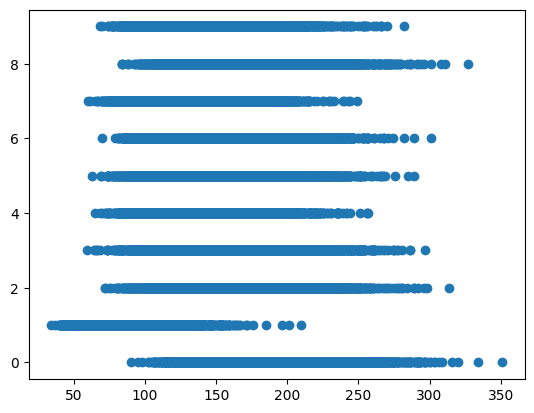

In [3]:
plt.scatter(train_X, train_y)

In [4]:
classes = np.unique(train_y)

What is the model here?

Let $N$ be the number of pixels in an image.

$$ x_i \sim \sum_{j=0}^{9} {\pi}_j\left(z\right) \, p_x\left(x_i \,; \, p_{z_j}, N\right) $$

where 
\begin{align}
    \pi\left(z\right) & = \text{Categorical}\left(\frac{1}{10},\frac{1}{10},\ldots, \frac{1}{10}\right) \\
    & = \text{prior prob of image }i\text{ coming from mixture component }j \\
\end{align}

$$ p_{z_j} = \text{prob of a pixel being ``on'' for cluster }j,$$ 

and 


\begin{align}
    p_x\left(x_i\, ; \, p_{z_j}, N\right) & = \text{Binomial}\left(x_i\,;\, p_{z_j}, N\right) \\
    & = \text{data likelihood}\\
\end{align}

In [5]:
def likelihood_obs(x, p_z, p_b, N):
    """Likelihood function for the mixture model.
    
        Args
            x: observed positive count
            N: observed total count
            p_z: vector of probabilities of obs. coming from each cluster
            p_b: vector of probabilities for each Binomial cluster

        Returns:
            p(x): the probability of observing x under this model.
    """
    likelihood_x_accum = torch.tensor(0.0)
    for i in range(len(p_z)):
        likelihood_x_accum += p_z[i] * torch.distributions.Binomial(total_count=N, probs=p_b[i]).log_prob(torch.tensor(x)).exp()
    return likelihood_x_accum.sum()

def likelihood_batch(X, p_z, p_b, N):
    """Compute the log-likelihood for a batch of inputs."""
    log_likelihood_accum = torch.tensor(0.0)
    for x in X:
        log_likelihood_accum += torch.log(likelihood_obs(x, p_z, p_b, N))
    return log_likelihood_accum


Perform SGD on the likelihood by tuning $p_z$ and $p_b$.

In [50]:
p_z = torch.distributions.Dirichlet(concentration=torch.tensor([1.0]*10)).sample()
p_z.requires_grad = True

p_b = torch.distributions.Uniform(low=0, high=1).sample(torch.tensor([10]))
p_b.requires_grad = True

import torch.nn.functional as F

n_imgs = len(train_X)

print(p_z)
for i in range(n_imgs):    
    likelihood_ = likelihood_obs(train_X[i], p_z, p_b, num_pixels)
    likelihood_.backward()
    with torch.no_grad():
        print(p_z.grad)
        p_z[:] = F.softmax(p_z + 0.01 * p_z.grad, dim=0)
        p_b[:] = torch.sigmoid(p_b + 0.01 * p_b.grad)

        print(p_z)
        break

        p_z.grad.zero_()
        p_b.grad.zero_()

tensor([0.0534, 0.1618, 0.1440, 0.1437, 0.0346, 0.2475, 0.0555, 0.0517, 0.0278,
        0.0799], requires_grad=True)
tensor([0.0000e+00, 2.1740e-02, 0.0000e+00, 0.0000e+00, 5.9946e-24, 1.4084e-02,
        1.5082e-18, 6.1180e-15, 0.0000e+00, 6.5595e-42])
tensor([0.0952, 0.1061, 0.1043, 0.1042, 0.0934, 0.1156, 0.0954, 0.0951, 0.0928,
        0.0978], requires_grad=True)


/tmp/ipykernel_23817/4151403332.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  likelihood_x_accum += p_z[i] * torch.distributions.Binomial(total_count=N, probs=p_b[i]).log_prob(torch.tensor(x)).exp()
